In [1]:
# Import the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Load the images and labels into a dataframe
data = []
labels = []
image_size = 224
for folder in ['emergency', 'non-emergency']:
    label = 1 if folder == 'emergency' else 0 
    for file in glob.glob(f'{folder}/*.jpg'): 
        image = cv2.imread(file) 
        image = cv2.resize(image, (image_size, image_size)) 
        data.append(image) 
        labels.append(label) 
data = np.array(data) / 255.0 # scale the pixel values to [0, 1]
labels = np.array(labels) 
df = pd.DataFrame({'data': list(data), 'labels': labels}) 
df.head()

,data,labels
0,"[[[0.5529411764705883, 0.5254901960784314, 0.4...",1
1,"[[[0.09411764705882353, 0.11372549019607843, 0...",1
2,"[[[0.7607843137254902, 0.7019607843137254, 0.6...",1
3,"[[[0.2196078431372549, 0.25882352941176473, 0....",1
4,"[[[0.16470588235294117, 0.3333333333333333, 0....",1


In [3]:
# Split the dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['data'].tolist(), df['labels'].tolist(), test_size=0.2, shuffle=True, random_state=42) 
X_train = np.array(X_train) 
X_test = np.array(X_test) 
y_train = np.array(y_train) 
y_test = np.array(y_test) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1316, 224, 224, 3) (330, 224, 224, 3) (1316,) (330,)


In [4]:
# Define the CNN architecture
base_model = tf.keras.applications.MobileNetV2(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet') 
base_model.trainable = True 
model = tf.keras.models.Sequential() 
model.add(base_model) 
model.add(tf.keras.layers.GlobalAveragePooling2D()) 
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # use sigmoid for binary output
model.add(tf.keras.layers.Dropout(0.2)) 
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 2225153 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [5]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()]) # use binary crossentropy and binary accuracy for binary classification

In [18]:
# Train the model
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_binary_accuracy', save_best_only=True, mode='max') # use val_binary_accuracy as the monitor
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, earlystop])

Epoch 1/50
42/42 [==============================] - 87s 2s/step - loss: 1.3352 - binary_accuracy: 0.9005 - val_loss: 0.7535 - val_binary_accuracy: 0.7788
Epoch 2/50
42/42 [==============================] - 80s 2s/step - loss: 1.2648 - binary_accuracy: 0.9096 - val_loss: 1.2429 - val_binary_accuracy: 0.7636
Epoch 3/50
42/42 [==============================] - 79s 2s/step - loss: 1.2615 - binary_accuracy: 0.9103 - val_loss: 0.8294 - val_binary_accuracy: 0.8424
Epoch 4/50
42/42 [==============================] - 76s 2s/step - loss: 1.4271 - binary_accuracy: 0.9027 - val_loss: 1.2087 - val_binary_accuracy: 0.8242
Epoch 5/50
42/42 [==============================] - 69s 2s/step - loss: 1.0905 - binary_accuracy: 0.9187 - val_loss: 0.3339 - val_binary_accuracy: 0.9091
Epoch 6/50
42/42 [==============================] - 83s 2s/step - loss: 1.1276 - binary_accuracy: 0.9240 - val_loss: 0.4119 - val_binary_accuracy: 0.9000
Epoch 7/50
42/42 [==============================] - 71s 2s/step - loss: 1.18

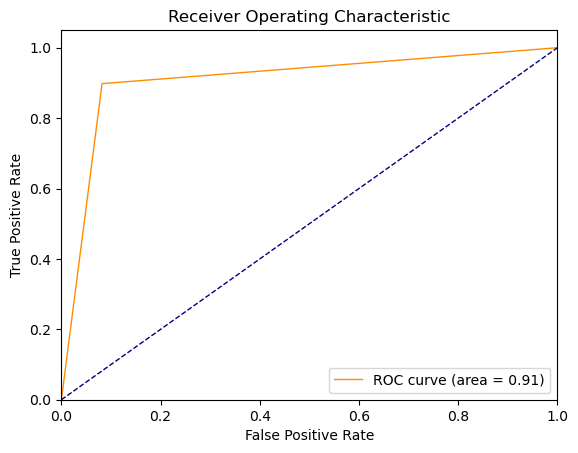

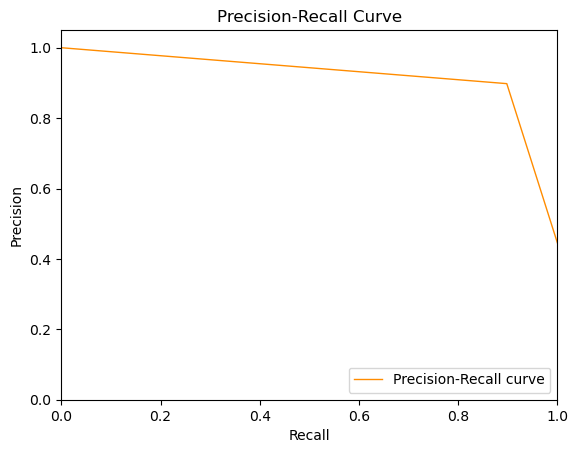

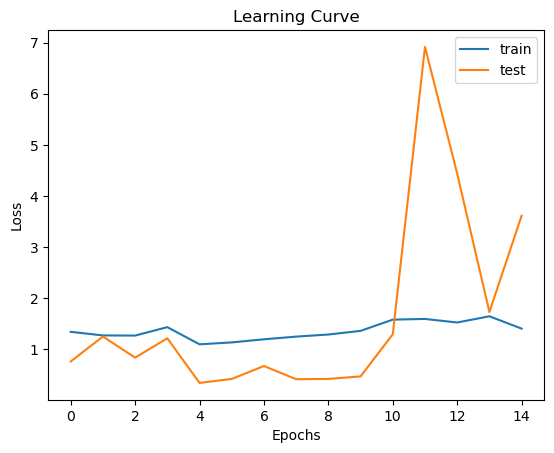

In [26]:
# Plot Graphs 
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label='Precision-Recall curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Learning Curve
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Evaluate the model
y_pred = model.predict(X_test) # get the probabilities
y_pred = np.where(y_pred > 0.5, 1, 0) # apply a threshold
acc = accuracy_score(y_test, y_pred) # calculate accuracy
prec = precision_score(y_test, y_pred) # calculate precision
rec = recall_score(y_test, y_pred) # calculate recall
f1 = f1_score(y_test, y_pred) # calculate F1-score
cm = confusion_matrix(y_test, y_pred) # calculate confusion matrix
print(f'Accuracy: {acc:.2f}')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'Confusion matrix:\n{cm}')

11/11 [==============================] - 3s 295ms/step
Accuracy: 0.91
Precision: 0.90
Recall: 0.90
F1-score: 0.90
Confusion matrix:
[[168  15]
 [ 15 132]]


In [1]:
# Label an image from the code
img = cv2.imread('991.jpg') # read the image
img = cv2.resize(img, (224, 224)) # resize the image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert the color
plt.imshow(img) # show the image
pred = model.predict(np.expand_dims(img, axis=0)) # get the probability
label = 1 if pred > 0.5 else 0 # apply a threshold
bbox = (0, 0, 224, 224) # use the whole image as the bounding box
classLabels = ['emergency', 'non-emergency'] # define the class names
cv2.rectangle(img, bbox, (255, 0, 0), 2) # draw a rectangle

# Calculate the size of the text and adjust the font size if necessary
text = classLabels[label]
font_scale = 3
while True:
    (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, font_scale, 3)
    if text_width < bbox[2] - 20: # if the text fits within the box, break the loop
        break
    font_scale -= 0.1 # otherwise, reduce the font size

# Calculate the position of the text
text_x = bbox[0] + 10 # start the text 10 pixels inside the left edge of the box
text_y = bbox[1] + text_height + 10 # start the text 10 pixels plus the height of the text inside the top edge of the box

cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_PLAIN, font_scale, (0, 255, 0), 3) # draw a text
plt.imshow(img) # show the labeled image

NameError: name 'cv2' is not defined

In [22]:
# Video Demo
cap = cv2.VideoCapture('Emergency.mp4') # Use 0 for webcam
font_scale = 3
font = cv2.FONT_HERSHEY_PLAIN
classLabels = ['emergency', 'non-emergency'] # define the class names

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Create a copy of the frame for the model prediction
    frame_for_pred = cv2.resize(frame, (image_size, image_size))
    frame_for_pred = cv2.cvtColor(frame_for_pred, cv2.COLOR_BGR2RGB)
    frame_for_pred = frame_for_pred / 255.0 # scale the pixel values to [0, 1]
    pred = model.predict(np.expand_dims(frame_for_pred, axis=0)) # get the probability

    # Use the original frame for displaying
    frame = cv2.resize(frame, (image_size, image_size))
    label = 1 if pred > 0.5 else 0 # apply a threshold
    bbox = (0, 0, image_size, image_size) # use the whole image as the bounding box
    
    cv2.rectangle(frame, bbox, (255, 0, 0), 2) # draw a rectangle
    # Calculate the size of the text and adjust the font size if necessary
    text = classLabels[label]
    font_scale = 3
    while True:
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, font_scale, 3)
        if text_width < bbox[2] - 20: # if the text fits within the box, break the loop
            break
        font_scale -= 0.1 # otherwise, reduce the font size

    # Calculate the position of the text
    text_x = bbox[0] + 10 # start the text 10 pixels inside the left edge of the box
    text_y = bbox[1] + text_height + 10 # start the text 10 pixels plus the height of the text inside the top edge of the box

    cv2.putText(frame, text, (text_x, text_y), cv2.FONT_HERSHEY_PLAIN, font_scale, (0, 255, 0), 3) # draw a text
                
    cv2.imshow('Emergency Vehicle Detection', frame)
                
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 48ms/step
